In [1]:
import camera.hamamatsu_camera as hc
import numpy as np
from matplotlib import pyplot as plt
import tifffile
import os

In [2]:
hcam = hc.HamamatsuCameraMR(camera_id=0)

camY = 256
camX = 2048
expTime = 20 #in msec
binFactor = 1
nFrames = 5
hcam.setPropertyValue("defect_correct_mode", "OFF") # keep defect mode on
hcam.setPropertyValue("readout_speed", 2) # 1 or 2. 2 is fastest mode
hcam.setPropertyValue("exposure_time", expTime/1000.0) # convert from msec to sec
hcam.setPropertyValue("subarray_hsize", camX)
hcam.setPropertyValue("subarray_vsize", camY)
hcam.setPropertyValue("subarray_vpos", 1024-camY/2)
hcam.setPropertyValue("binning", binFactor)

# Set trigger properties
hcam.setPropertyValue("trigger_source", 'INTERNAL') # 1 (internal), 2 (external), 3 (software)
hcam.setPropertyValue("trigger_mode", 'START') # 1 (normal), 6 (start)
hcam.setPropertyValue("trigger_active", 'EDGE') # 1 (edge), 2 (level), 3 (syncreadout)
hcam.setPropertyValue("trigger_polarity", 'POSITIVE') # 1 (negative), 2 (positive)

hcam.setACQMode("fixed_length", nFrames)

 unknown property name: readout_speed
max camera backlog was: 0


In [3]:
im = np.zeros((nFrames, camY, camX), dtype = 'uint16') #3D image
hcam.startAcquisition()
count_old = 0
count_new = 0
count = 0
while count < nFrames - 1:
    [frames, dims] = hcam.getFrames() #frames stored as objects
    count_old = count
    for aframe in frames:
        np_data = aframe.getData() #np_data is individual camera frame stored as 1D array
        print(np_data.max())
        im[count] = np.reshape(np_data, (camY, camX)) #append the frame to the 3D image 'im'
        r,c = np.where(im[count,:,:] == im[count,:,:].max())
        print(r,c)
        print(np.mean(np_data)) #mean value of frame
#         print(im[count,r,c]) 

        count += 1
    count_new = count
    if count_new == count_old:
        count = nFrames
hcam.stopAcquisition()

6923
[248] [1922]
844.9424304962158
6996
[248] [1922]
824.7042140960693
7181
[248] [1922]
812.8545246124268
7106
[248] [1922]
824.6545219421387
max camera backlog was: 1


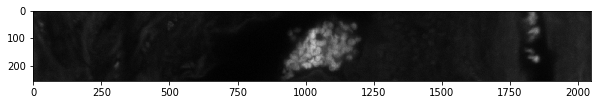

In [4]:
plt.figure(figsize = (10,5))
plt.imshow(im[0,:,:],cmap = 'gray')

In [5]:
os.chdir('C://Users//AERB//Documents//3rd Gen LSM//Fall2020_scope//Hamamatsu_troubleshoot_10_1_20')

In [6]:
tifffile.imwrite('im3D_jupyter_biopsy_2mW_20ms.tif',im)

In [17]:
hcam.shutdown()

## Try writing HDF5 file with B3D compression, similar to how it is written in lsmfx

In [1]:
import camera.hamamatsu_camera as hc
import numpy as np
from matplotlib import pyplot as plt
import h5py
import tifffile
import os
import gc
import time
import utils.utils as utils

In [2]:
hcam = hc.HamamatsuCameraMR(camera_id=0)
print(hcam)

In [3]:
camY = 256
camX = 2048
expTime = 20 #in msec
binFactor = 1
nFrames = 2048
# Set camera properties
hcam.setPropertyValue("defect_correct_mode", "OFF") # keep defect mode on
hcam.setPropertyValue("readout_speed", 2) # 1 or 2. 2 is fastest mode
hcam.setPropertyValue("exposure_time", expTime/1000.0) # convert from msec to sec
hcam.setPropertyValue("subarray_hsize", camX)
hcam.setPropertyValue("subarray_vsize", camY)
hcam.setPropertyValue("subarray_vpos", 1024-camY/2)
hcam.setPropertyValue("binning", binFactor)

# Set trigger properties
hcam.setPropertyValue("trigger_source", 'INTERNAL') # 1 (internal), 2 (external), 3 (software)
hcam.setPropertyValue("trigger_mode", 'START') # 1 (normal), 6 (start)
hcam.setPropertyValue("trigger_active", 'EDGE') # 1 (edge), 2 (level), 3 (syncreadout)
hcam.setPropertyValue("trigger_polarity", 'POSITIVE') # 1 (negative), 2 (positive)

hcam.setACQMode("fixed_length", nFrames)

 unknown property name: readout_speed
max camera backlog was: 0


In [4]:
imgShape = (nFrames, camY, camX) 
chunkSize1 = 256/binFactor
chunkSize2 = 32/binFactor #for Z (256px) direction
chunkSize3 = 256/binFactor

drive = 'C'
save_dir = 'Users//AERB//Documents//3rd Gen LSM//Fall2020_scope//Hamamatsu_troubleshoot_10_1_20'
xWidth = 0.209
yStitchOverlay = 0.3825
zStitchOverlay = .03

In [5]:
write_threads = []
im = np.zeros((nFrames, camY, camX), dtype = 'uint16') #initialize: "X" (scan) direction, Z (256px) direction, Y direction
idx = 0
folder = 'C://Users//AERB//Documents//3rd Gen LSM//Fall2020_scope//Hamamatsu_troubleshoot_10_1_20'
dest = folder + '//data.h5'
f = h5py.File(dest,'a')
# data = f.require_dataset('/t00000/s' + str(idx).zfill(2) + '/' + str(0) + '/cells', chunks = (chunkSize1, chunkSize2, chunkSize3), dtype = 'int16', shape = imgShape, compression = 32016, compression_opts=(round(2*1000), 1, round(2.1845*1000), 0, round(1.6*1000)))


In [6]:
nWavelengths = 1
yTiles = 2
zTiles = 2
idx_LB = 0
for j in range(zTiles): 
    for k in range(yTiles): 
        for i in range(nWavelengths):
            print('k = ' + str(k))
            idx = k+j*yTiles+i*yTiles*zTiles
            idx_tile = k+j*yTiles
            idx_channel = i
            if idx == 0:
                tgroup = f.create_group('/t00000')
            resgroup = f.create_group('/t00000/s' + str(idx).zfill(2) + '/' + str(0))
#             data = f.require_dataset('/t00000/s' + str(idx).zfill(2) + '/' + str(0) + '/cells', chunks = (chunkSize1, chunkSize2, chunkSize3), dtype = 'int16', shape = imgShape)
            data = f.require_dataset('/t00000/s' + str(idx).zfill(2) + '/' + str(0) + '/cells', chunks = (chunkSize1, chunkSize2, chunkSize3), dtype = 'uint16', shape = imgShape, compression = 32016, compression_opts=(round(2*1000), 1, round(2.1845*1000), 0, round(1.6*1000)))

            hcam.startAcquisition() #start camera acquisition
            count_old = 0
            count_new = 0
            count = 0
            while count < nFrames-1:
                time.sleep(0.01)
                # Get frames.
            #     print('getting frames')
                [frames, dims] = hcam.getFrames()
                count_old = count
                # Save frames.
                for aframe in frames:
                    np_data = aframe.getData()
                    #im.append(numpy.reshape(np_data, (camY, camX)))
                    #im[count] = numpy.clip(numpy.reshape(np_data, (camY, camX)) - bkg, 100*binFactor*binFactor, 65535) - 100*binFactor*binFactor
                    im[count] = np.reshape(np_data, (camY, camX)) #orient so camera's vertical FOV is row direction
                    count += 1
                count_new = count
                if count_new == count_old:
                    count = nFrames #reached last frame in scan
#                 print(str(count_new) + '/' + str(nFrames) + ' frames collected...')
                data[count_old:count_new] = im[count_old:count_new]
            print('frame grab complete')
            if idx_LB > 0: #
                previous_thread = write_threads[idx_LB-1]
                while previous_thread.alive() == True:
                    time.sleep(0.1)
            current_thread = utils.writeBDV(f, im, idx, binFactor)
            write_threads.append(current_thread)
            current_thread.start()
            
            if idx == (nWavelengths*yTiles*zTiles-1):
                current_thread.join()
            
            time.sleep(2)
            hcam.stopAcquisition()
            time.sleep(2)
            gc.collect()
            idx_LB += 1
            


k = 0
frame grab complete
max camera backlog was: 45
k = 1
frame grab complete
max camera backlog was: 45
k = 0
frame grab complete
max camera backlog was: 44
k = 1
frame grab complete
max camera backlog was: 44


In [7]:
utils.write_xml(drive = drive, save_dir = save_dir, idx = idx, idx_tile = idx_tile, idx_channel = idx_channel, channels = nWavelengths, tiles_y = yTiles, tiles_z = zTiles, sampling = xWidth, binning = binFactor, offset_y = yStitchOverlay, offset_z = zStitchOverlay, x = imgShape[0], y = imgShape[1], z = imgShape[2])

Writing BigDataViewer XML file...


In [8]:
array = f['t00000/s00/0/cells'][:]

In [9]:
array.max()

7161

In [10]:
array.min()

0

In [11]:
type(array[0,0,0])

numpy.uint16

In [12]:
hcam.shutdown()
f.close()

## Read previously saved HDF5 file

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import tifffile
import os
import time

In [6]:
folder = 'C://Users//AERB//Documents//3rd Gen LSM//Fall2020_scope//Hamamatsu_troubleshoot_10_1_20//'

file = 'data_uint16.h5'
f = h5py.File(folder + file,'r')
im = f['t00000/s00/0/cells'][:]

In [7]:
im.max()

31662

## Try writing HDF5 file without B3D compression, similar to how it is written in lsmfx

In [1]:
import camera.hamamatsu_camera as hc
import numpy as np
from matplotlib import pyplot as plt
import h5py
import tifffile
import os
import gc
import time
import utils.utils as utils

In [2]:
hcam = hc.HamamatsuCameraMR(camera_id=0)
print(hcam)

In [3]:
camY = 256
camX = 2048
expTime = 20 #in msec
binFactor = 1
nFrames = 2048
# Set camera properties
hcam.setPropertyValue("defect_correct_mode", "OFF") # keep defect mode on
hcam.setPropertyValue("readout_speed", 2) # 1 or 2. 2 is fastest mode
hcam.setPropertyValue("exposure_time", expTime/1000.0) # convert from msec to sec
hcam.setPropertyValue("subarray_hsize", camX)
hcam.setPropertyValue("subarray_vsize", camY)
hcam.setPropertyValue("subarray_vpos", 1024-camY/2)
hcam.setPropertyValue("binning", binFactor)

# Set trigger properties
hcam.setPropertyValue("trigger_source", 'INTERNAL') # 1 (internal), 2 (external), 3 (software)
hcam.setPropertyValue("trigger_mode", 'START') # 1 (normal), 6 (start)
hcam.setPropertyValue("trigger_active", 'EDGE') # 1 (edge), 2 (level), 3 (syncreadout)
hcam.setPropertyValue("trigger_polarity", 'POSITIVE') # 1 (negative), 2 (positive)

hcam.setACQMode("fixed_length", nFrames)

 unknown property name: readout_speed
max camera backlog was: 0


In [4]:
imgShape = (nFrames, camY, camX) 
chunkSize1 = 256/binFactor
chunkSize2 = 32/binFactor #for Z (256px) direction
chunkSize3 = 256/binFactor

drive = 'C'
save_dir = 'Users//AERB//Documents//3rd Gen LSM//Fall2020_scope//Hamamatsu_troubleshoot_10_1_20'
xWidth = 0.209
yStitchOverlay = 0.3825
zStitchOverlay = .03

In [5]:
write_threads = []
im = np.zeros((nFrames, camY, camX), dtype = 'uint16') #initialize: "X" (scan) direction, Z (256px) direction, Y direction
idx = 0
folder = 'C://Users//AERB//Documents//3rd Gen LSM//Fall2020_scope//Hamamatsu_troubleshoot_10_1_20'
dest = folder + '//data.h5'
f = h5py.File(dest,'a')
# data = f.require_dataset('/t00000/s' + str(idx).zfill(2) + '/' + str(0) + '/cells', chunks = (chunkSize1, chunkSize2, chunkSize3), dtype = 'int16', shape = imgShape, compression = 32016, compression_opts=(round(2*1000), 1, round(2.1845*1000), 0, round(1.6*1000)))


In [6]:
nWavelengths = 1
yTiles = 2
zTiles = 2
idx_LB = 0
for j in range(zTiles): 
    for k in range(yTiles): 
        for i in range(nWavelengths):
            print('k = ' + str(k))
            idx = k+j*yTiles+i*yTiles*zTiles
            idx_tile = k+j*yTiles
            idx_channel = i
            if idx == 0:
                tgroup = f.create_group('/t00000')
            resgroup = f.create_group('/t00000/s' + str(idx).zfill(2) + '/' + str(0))
            data = f.require_dataset('/t00000/s' + str(idx).zfill(2) + '/' + str(0) + '/cells', chunks = (chunkSize1, chunkSize2, chunkSize3), dtype = 'uint16', shape = imgShape) #no B3D compression
#             data = f.require_dataset('/t00000/s' + str(idx).zfill(2) + '/' + str(0) + '/cells', chunks = (chunkSize1, chunkSize2, chunkSize3), dtype = 'uint16', shape = imgShape, compression = 32016, compression_opts=(round(2*1000), 1, round(2.1845*1000), 0, round(1.6*1000)))

            hcam.startAcquisition() #start camera acquisition
            count_old = 0
            count_new = 0
            count = 0
            while count < nFrames-1:
                time.sleep(0.01)
                # Get frames.
            #     print('getting frames')
                [frames, dims] = hcam.getFrames()
                count_old = count
                # Save frames.
                for aframe in frames:
                    np_data = aframe.getData()
                    #im.append(numpy.reshape(np_data, (camY, camX)))
                    #im[count] = numpy.clip(numpy.reshape(np_data, (camY, camX)) - bkg, 100*binFactor*binFactor, 65535) - 100*binFactor*binFactor
                    im[count] = np.reshape(np_data, (camY, camX)) #orient so camera's vertical FOV is row direction
                    count += 1
                count_new = count
                if count_new == count_old:
                    count = nFrames #reached last frame in scan
#                 print(str(count_new) + '/' + str(nFrames) + ' frames collected...')
                data[count_old:count_new] = im[count_old:count_new]
            print('frame grab complete')
            if idx_LB > 0: #
                previous_thread = write_threads[idx_LB-1]
                while previous_thread.alive() == True:
                    time.sleep(0.1)
            current_thread = utils.writeBDV(f, im, idx, binFactor)
            write_threads.append(current_thread)
            current_thread.start()
            
            if idx == (nWavelengths*yTiles*zTiles-1):
                current_thread.join()
            
            time.sleep(2)
            hcam.stopAcquisition()
            time.sleep(2)
            gc.collect()
            idx_LB += 1
            


k = 0
frame grab complete
max camera backlog was: 9
k = 1
frame grab complete
max camera backlog was: 10
k = 0
frame grab complete
max camera backlog was: 9
k = 1
frame grab complete
max camera backlog was: 10


In [7]:
utils.write_xml(drive = drive, save_dir = save_dir, idx = idx, idx_tile = idx_tile, idx_channel = idx_channel, channels = nWavelengths, tiles_y = yTiles, tiles_z = zTiles, sampling = xWidth, binning = binFactor, offset_y = yStitchOverlay, offset_z = zStitchOverlay, x = imgShape[0], y = imgShape[1], z = imgShape[2])

Writing BigDataViewer XML file...


In [8]:
array = f['t00000/s00/0/cells'][:]

In [9]:
array.max()

65535

In [10]:
array.min()

0

In [11]:
type(array[0,0,0])

numpy.uint16

In [11]:
hcam.shutdown()
f.close()